## Quick Reference

See [here](http://graylab.jhu.edu/pyrosetta/downloads/documentation/pyrosetta4_online_format/PyRosetta4_Workshops_Appendix_A.pdf)

In [53]:
%matplotlib inline

import pyrosetta
import numpy as np
import matplotlib.pyplot as plt

In [54]:
pyrosetta.init()
pmm = pyrosetta.PyMOLMover()
sf = pyrosetta.get_fa_scorefxn()

Found rosetta database at: /Users/sanyamkapoor/Workspace/mlenv/lib/python3.6/site-packages/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python36.mac 2018.13+release.e0d86740ed3e0d86740ed30e28fc16f36793f608bbc5ce7eaf9 2018-03-31T08:07:21] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python36.mac r175 2018.13+release.e0d86740ed3 e0d86740ed30e28fc16f36793f608bbc5ce7eaf9 http://www.pyrosetta.org 2018-03-31T08:07:21
core.init: command: PyRosetta -ex1 -ex2aro -database /Users/sanyamkapoor/Workspace/mlenv/lib/python3.6/site-packages/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=1593316822 seed_offset=0 real_seed=1593316822
core.init.random: RandomGenerator:init: Normal mode, seed=1593316822 RG_type=mt19937
core.scori

### Perturbations

In [55]:
def perturb(pose, num_steps=1, b=10.0):
    n_residue = pose.total_residue()
    for step in range(num_steps):
        r = np.random.randint(1, n_residue + 1)
        angle_params = np.array([
            pose.phi(r),
            pose.psi(r),
            pose.omega(r),
            *pose.residue(r).chi()
        ])
        angle_params += np.random.laplace(0.0, b, len(angle_params))
        phi, psi, omega, *chi = angle_params.tolist()

        pose.set_phi(r, phi)
        pose.set_psi(r, psi)
        pose.set_omega(r, omega)
        for i, chi_i in enumerate(chi):
            pose.set_chi(i + 1, r, chi_i)

In [56]:
orig_pose = pyrosetta.pose_from_pdb('3rx6_trimmed.pdb')
pose = pyrosetta.Pose()
pose.assign(orig_pose)

core.import_pose.import_pose: File '3rx6_trimmed.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LYS:CtermProteinFull 16


In [57]:
perturb(pose, num_steps=2000, b=20.0)

print('Original Pose: {}, Perturbed Pose: {}'.format(sf(orig_pose), sf(pose)))

Original Pose: 1.1106370012416842, Perturbed Pose: 37262.44589565463


In [58]:
scores = []
max_lb = 20.0
min_lb = 0.1
cur_lb = max_lb
max_step = 20000
T = 1.0

mc_pose = pyrosetta.Pose()
mc_pose.assign(pose)
for t in range(1, max_step + 1):
    perturb(mc_pose)

    prev_score = sf(pose)
    score = sf(mc_pose)
    delta = score - prev_score
    if delta < 0:
        pose.assign(mc_pose)
    else:
        # kT = 1.0 resembles room temperature
        
        threshold = np.exp(- delta)
        p = np.random.rand()
        if p < threshold:
            pose.assign(mc_pose)
        else:
            mc_pose.assign(pose)

    scores.append(prev_score)
    
    # Send to PyMOL
    # pmm.apply(pose)
    # pmm.send_energy(pose)
    
    print('{}/{}'.format(t, max_step), end='\r')

137.09210335217995


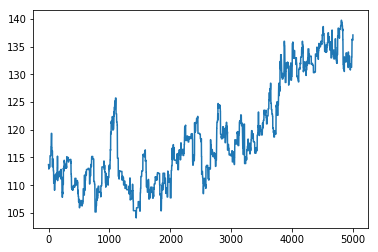

In [59]:
print(scores[-1])
plt.plot(list(range(5000)), scores[-5000:])
plt.show()